In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img_size = 256
epochs = 50
batch_size = 128
channels = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/archive-eyes",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = batch_size)

Found 4217 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
len(dataset)

33

In [ ]:
for images_batch,label_batch in dataset.take(1):
  print(images_batch.shape)
  print(label_batch.numpy())

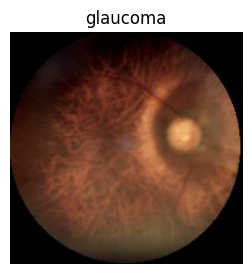

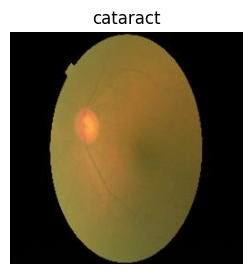

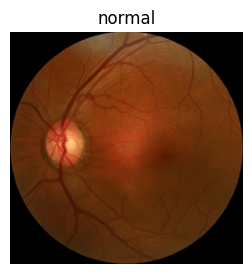

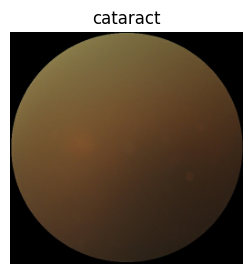

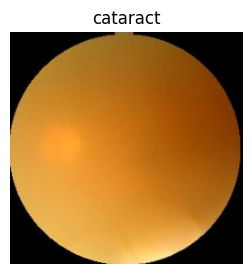

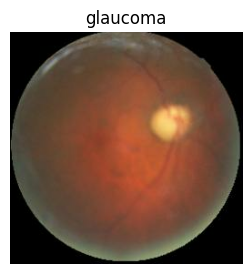

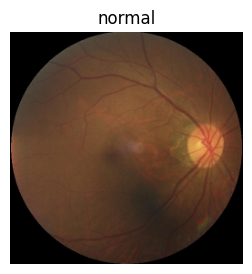

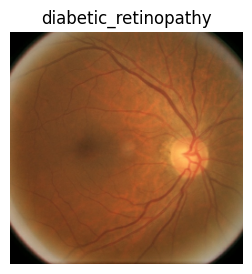

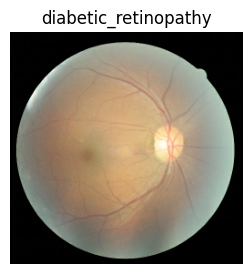

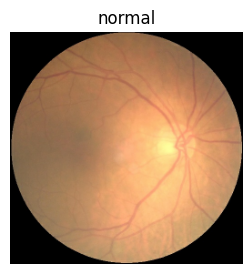

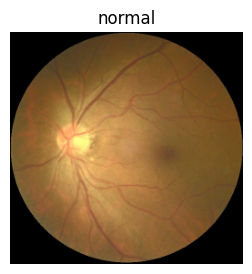

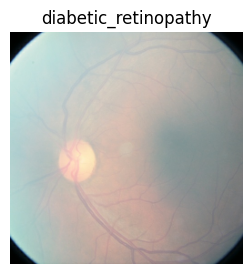

In [ ]:
for images_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplots(1,1,figsize=(3,4))
    plt.imshow(images_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [ ]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds


In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [ ]:
len(train_ds)

26

In [ ]:
len(val_ds)

3

In [ ]:
len(test_ds)

4

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#pre-processing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.5)
])

In [ ]:
#defining the model
model = tf.keras.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape = (256,256,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
26/26 [==============================] - 924s 2s/step - loss: 17.4634 - acc: 0.2797 - val_loss: 1.3997 - val_acc: 0.3281
Epoch 2/50
26/26 [==============================] - 6s 227ms/step - loss: 1.8148 - acc: 0.3011 - val_loss: 1.2425 - val_acc: 0.4609
Epoch 3/50
26/26 [==============================] - 6s 232ms/step - loss: 1.3650 - acc: 0.3529 - val_loss: 1.1547 - val_acc: 0.4635
Epoch 4/50
26/26 [==============================] - 6s 231ms/step - loss: 1.2995 - acc: 0.3836 - val_loss: 1.1350 - val_acc: 0.4922
Epoch 5/50
26/26 [==============================] - 6s 233ms/step - loss: 1.2541 - acc: 0.4038 - val_loss: 1.1420 - val_acc: 0.5052
Epoch 6/50
26/26 [==============================] - 6s 232ms/step - loss: 1.2423 - acc: 0.4128 - val_loss: 1.1981 - val_acc: 0.5521
Epoch 7/50
26/26 [==============================] - 6s 228ms/step - loss: 1.2447 - acc: 0.4161 - val_loss: 1.0778 - val_acc: 0.5417
Epoch 8/50
26/26 [==============================] - 6s 229ms/step - loss: 1.

In [ ]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 32s 111ms/step - loss: 0.3228 - acc: 0.8906


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

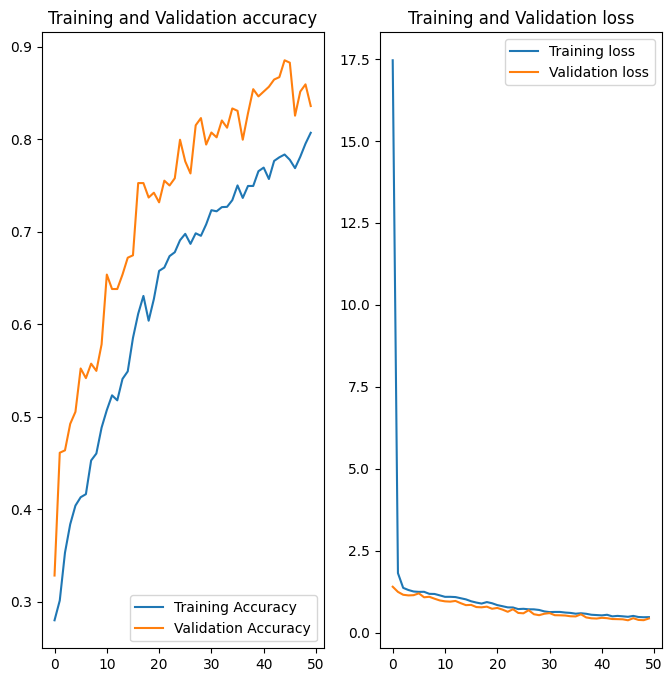

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label='Training loss')
plt.plot(range(epochs),val_loss,label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

first image to predict
actual label:  glaucoma
4/4 [==============================] - 0s 36ms/step
predicted label:  glaucoma


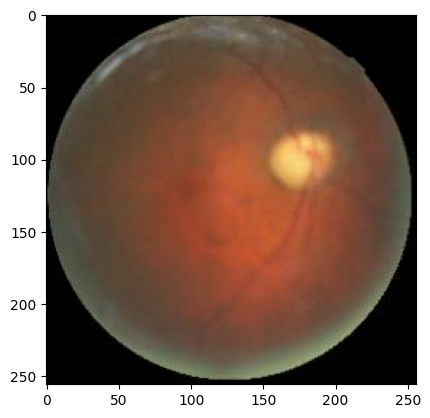

In [ ]:
for images_batches, labels_batch in test_ds.take(1):
  first_image = images_batch[5].numpy().astype('uint8')
  first_label = labels_batch[5].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label: ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label: ", class_names[np.argmax(batch_prediction[5])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 25ms/step


<ipython-input-50-eedd199f8b58>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust the spacing between subplots


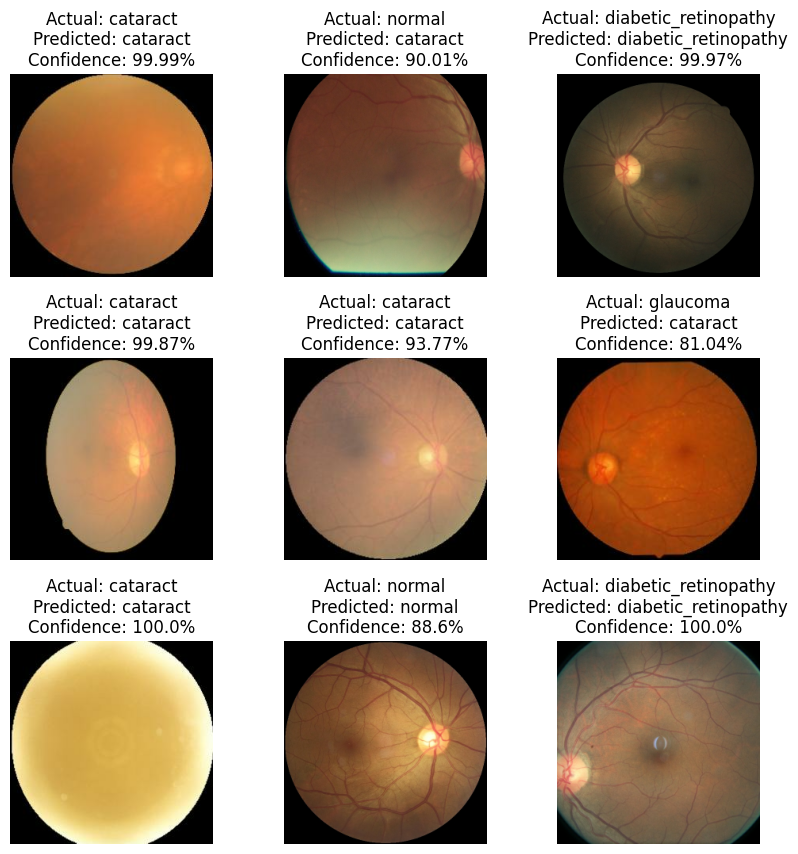

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
#         ax = plt.subplot(3, 3, i+1)
#         img = images[i].numpy().astype("uint8")
#         plt.imshow(img)
#         predicted_class, confidence = predict(model, img)
#         actual_class = class_names[labels[i]]
#         print("\n")
#         plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
#         plt.axis("off")

import matplotlib.gridspec as gridspec

plt.figure(figsize=(10, 10))

# Create a gridspec with 2 rows and 3 columns
grid_spec = gridspec.GridSpec(3, 3, hspace=0.4)

for images, labels in test_ds.take(1):
    for i in range(9):
        # Get the current grid position based on the iteration
        grid_pos = grid_spec[i]

        # Create a subplot using the grid position
        ax = plt.subplot(grid_pos)

        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence = predict(model, img)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()